![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+GenAI+For+Document+Q%26A+-+Local+Government+Trends.ipynb)

# Document Q&A: Local Government Trends

Based on Document Q&A Version 2 Notebooks

**What?**

Ask question of a market report on local government trends.  

**Sources:**

PDFs:
- [2023 Look Ahead: 25 Topics to Watch in Local Governments This Year](https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf) - 13 pages.
- [How Local Governments Have Taken Advantage of Major Federal Programs](https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf) - 12 pages.
- Source: Curate, Part of FiscalNote

**Tools:**
- Vertex AI LLM Embedding API
  - `vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('embedding-gecko@001')`
- Vertex AI GenAI Language Model API
  - `vertexai.preview.language_models.TextGenerationModel.from_pretrained('text@bison-001')`
- Input file processing into documents/elements with GCP Document AI
  - `google.cloud.documentai.DocumentProcessorServiceClient()`
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook

---

**Google Cloud Vertex AI Generative AI Support**

Vertex AI Generative AI gives access to Google's large genearative AI models and also enables you to test, tune, and deploy them for your applications. Get an overview [here](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

---

**How:**

- Create documents from the source information.
  - <u>Definition</u>: a document is a section of the rules
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

**What is Unique?**

An LLM is likely unexposed to a users private content.  This appoach constructs a summarization prompt for an LLM by first retriving context for the question from the users documents using embeddings.  This also allows the response to be accompanied by direct reference to the users documentation used in the prompt.

**Notes**

- An LLM is likely trained on many sources that probably include lots of general knowledge, even information like what is used here.  It is also likely knowledgable of past outdated information which can be a benefit - or detriment - to accuracy.  This approach directly uses the version of the document that currently applies.

**Prerequisites**

This notebook uses Vertex AI and Document AI services for processing data while also using Google Cloud Storage And Google BigQuery for data storage and retrieval.  If you are running this notebook from Colab or another environment where your user id is authenticated then your account will need roles/permissions that allow working with these services.  If you are running this from a Vertex AI Workbench Notebook instance then it is running as a service account which will need the roles/permission that allow working with these services.  

**References**

- [Vertex AI GenAI Studio](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)
    - Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)
- [Document AI](https://cloud.google.com/document-ai/docs/overview)
    - Document AI [Parsers](https://cloud.google.com/document-ai/docs/processors-list)
    - Document AI [Python Client](https://cloud.google.com/python/docs/reference/documentai/latest)

---
## Overview

<p><center>
    <img alt="Overview Chart" src="../architectures/notebooks/applied/genai/doc_qa.png" width="55%">
</center><p>


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20GenAI%20For%20Document%20Q&A%20-%20Local%20Government%20Trends.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

In [ ]:
# Vertex AI GenAI Studio SDK - Update the aiplatform SDK
!pip install google.cloud.aiplatform -U -q --user

# for working with embeddings locally
!pip install scann -q --user

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q --user
!pip install PyPDF2 -U -q --user
!pip install Pillow -U -q --user

In [47]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI For This Project
!gcloud services enable aiplatform.googleapis.com

The `aiplatform` version needs to be 1.25.0 or higher for the LLM functionality:

In [3]:
import google.cloud.aiplatform as aiplatform
aiplatform.__version__

'1.25.0'

**RESTART RUNTIME**

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'local-government-trends'
SERIES = 'applied-genai-v2'

# save results in: GCS, BQ, ALL
SAVE_IN = 'ALL'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT

# location for the source documents (PDF): can be http:// or gs://, a list of one or more document links
source_documents = [
    'https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf',
    'https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf',
    './path/to/something.rtf'
]

# If a prior run is available then:
# a value of True will trigger loading it from RETRIEVE_FROM,
# a value of False will trigger removing (if exist) from all possible sources.  This forces a regeneration when needed.
USE_PRIOR_RUN = True

# first question to ask
question = "Which policy issues are covered by the reports?"

Packages

In [3]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np
import pandas as pd

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage
from google.cloud import bigquery

2023-06-05 20:54:39.437301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 20:54:42.797678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-05 20:54:42.797831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Clients

In [4]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

---
## Vertex LLM Setup

- TextEmbeddingModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings)
    - TextEmbeddingModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextEmbeddingModel)
- TextGenerationModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/text/test-text-prompts)
    - TextGenerationModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextGenerationModel)

In [5]:
# create links to model: embedding api and text generation
embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [6]:
question

'Which policy issues are covered by the reports?'

In [7]:
embedding_model.get_embeddings([question])[0].values[0:5]

[0.048854246735572815,
 0.0007858292083255947,
 -0.02215433306992054,
 -0.041435908526182175,
 -0.004033405799418688]

Test test generation (llm) model:

In [8]:
question

'Which policy issues are covered by the reports?'

In [9]:
textgen_model.predict(question)

The reports cover a wide range of policy issues, including:

* Economic growth and development
* Poverty reduction
* Social protection
* Gender equality
* Climate change
* Sustainable development
* Human rights
* Governance
* Peace and security

The reports are based on a variety of sources, including:

* Official statistics
* Research studies
* Interviews with experts and stakeholders
* Public consultations

The reports are produced by a team of experts from the World Bank Group, in collaboration with governments, development partners, and civil society organizations.

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [10]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/1026793852137/locations/us/processors/99dc9d70b803f826"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/1026793852137/locations/us/processors/99dc9d70b803f826:process"
create_time {
  seconds: 1683799767
  nanos: 293339000
}
default_processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-form-parser-v1.0-2020-09-23"

---
## Get The Documents

Get the source PDF(s) from GCS or a URL and store as a list of pages for each file: `file_pages`.

Get Location of Files

In [11]:
document_locations = []
for source_document in source_documents:
    if source_document.startswith('http'):
        document_locations.append('URL')
        print(f'Use requests to get online document: {source_document}')
    elif source_document.startswith('gs'):
        document_locations.append('GCS')
        print(f'Use GCS to get document in GCS: {source_document}')
    else:
        document_locations.append('UNKNOWN')
        print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use requests to get online document: https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf
Use requests to get online document: https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf
The source_document variable points to a document in an unknown location type (not gs:// or http): ./path/to/something.rtf


Import the PDF to memory as bytes:

In [12]:
imported_documents = []
for s, source_document in enumerate(source_documents):
    if document_locations[s] == 'URL':
        imported_documents.append(requests.get(source_document).content)
    elif document_locations[s] == 'GCS':
        blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
        imported_documents.append(blob.download_as_bytes())
    elif document_locations[s] == 'UNKNOWN':
        imported_documents.append(None)

In [13]:
type(imported_documents[0])

bytes

Convert from bytes to PDF:

In [14]:
converted_documents = []
for imported_document in imported_documents:
    if imported_document:
        converted_documents.append(PyPDF2.PdfReader(io.BytesIO(imported_document)))
    else:
        converted_documents.append(None)

In [15]:
type(converted_documents[0])

PyPDF2._reader.PdfReader

Review number of pages per PDF:

In [16]:
for f, file in enumerate(converted_documents):
    if file:
        print(f"{source_documents[f]} has {len(file.pages)} pages")

https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf has 13 pages
https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf has 12 pages


Split PDF(s) in list of individual pages for each file:

In [17]:
raw_files_pages = []
for converted_document in converted_documents:
    if converted_document:
        pages = []
        for page_num, page in enumerate(converted_document.pages, 1):
            writer = PyPDF2.PdfWriter()
            writer.add_page(page)
            with io.BytesIO() as bytes_stream:
                pages.append(writer.write(bytes_stream)[1].getbuffer().tobytes())
        raw_files_pages.append(pages)
    else:
        raw_files_pages.append(None)

---
## Retrieve Files From Previous Run on GCS Or BigQuery

This uses the input parameter set above: `RETRIEVE_FROM`.  If it is set to `BQ` or `GCS` then it will check the source for an available prior run and retrieve it if it exists.


Function to check for existance of BigQuery Table:

In [18]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        return True
    except NotFound:
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'), bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages_elements')

(False, False)

In [19]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False
    
    if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
        print(f'Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
        print(f'Previous results exists in BQ but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
        
elif RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
    print('Copying previous run from GCS')
    
    # load files_pages: the raw data from docai parsing
    # read file into list
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
    raw_files_pages = [json.loads(line) for line in blob.download_as_text().splitlines()]
    # get dimensions for list (files) of list (pages)
    file_indexes = list(set([page['file_index'] for page in raw_files_pages]))
    page_indexes = [0] * len(file_indexes)
    for page in raw_files_pages:
        if page['page_index'] is not None:
            if page['page_index'] > page_indexes[page['file_index']]: page_indexes[page['file_index']] = page['page_index']
    # shape input to expected list of list
    files_pages = [[None] * (i+1) for i in page_indexes]
    for page in raw_files_pages:
        if page['page_index'] is not None:
            files_pages[page['file_index']][page['page_index']] = page['page']
    
    # load files_pages_elements: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_elements.json')
    files_pages_elements = [json.loads(line) for line in blob.download_as_text().splitlines()]   
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    
elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
    print('Copying previous run from BigQuery')
    
    # load files_pages: the raw data from docai parsing
    # read file into list
    raw_files_pages = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages` ORDER BY file_index, page_index').to_dataframe().to_dict('records')
    # get dimensions for list (files) of list (pages)
    file_indexes = list(set([page['file_index'] for page in raw_files_pages]))
    page_indexes = [0] * len(file_indexes)
    for page in raw_files_pages:
        if page['page_index'] is not pd.NA:
            if page['page_index'] > page_indexes[page['file_index']]: page_indexes[page['file_index']] = page['page_index']
    # shape input to expected list of list
    files_pages = [[None] * (i+1) for i in page_indexes]
    for page in raw_files_pages:
        if page['page_index'] is not pd.NA:
            files_pages[page['file_index']][page['page_index']] = page['page']
    
    # load files_pages_elements: the perpared results from the docai parsing results
    files_pages_elements = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages_elements` ORDER BY metadata.vme_id').to_dataframe().to_dict('records') 
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    
else:
    print('No previous run available to copy over')
    PRIOR_PARSE = False

No previous run available to copy over


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [20]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [21]:
def docai_runner(p, start, raw_document_page):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document_page, name = parser.name)))

In [22]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    files_pages = []
    for n, pages in enumerate(raw_files_pages):
        if pages:
            print(f"The Expected runtime for parsing document {n + 1} of {len(raw_files_pages)} is {(len(pages)/adjust_rate_limit):.2f} minutes")
            file_pages = [None] * len(pages)
            start = time.time()
            with concurrent.futures.ThreadPoolExecutor(max_workers = len(pages)) as executor:
                futures = [
                    executor.submit(
                        docai_runner,
                        p, start,
                        documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
                    ) for p, pdf in enumerate(pages)
                ]
                for future in concurrent.futures.as_completed(futures):
                    file_pages[future.result()[0]] = (Document.to_dict(future.result()[1].document))
            files_pages.append(file_pages)
        else:
            files_pages.append(None)

No Prior Results, Parsing with Document AI
The Expected runtime for parsing document 1 of 3 is 0.22 minutes
The Expected runtime for parsing document 2 of 3 is 0.20 minutes


For each pages dictionary, add the path, file, page, and embedding of the full full pages OCR results:

In [23]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Using Document AI Parsing')
    for f, file in enumerate(files_pages):
        if file:
            
            for p, page in enumerate(file):
                document_image = PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(page['pages'][0]['image']['content'].encode('utf-8'))
                    )
                )
                page['path'] = source_documents[f][:(-1*len(source_documents[f].split('/')[-1]))]
                page['file'] = source_documents[f].split('/')[-1]
                page['page'] = p+1
                page['vme_id'] = f'{f}_{p}'
                page['dimensions'] = document_image.size
                if page['text']:
                    page['embedding'] = embedding_model.get_embeddings([page['text']])[0].values
                else:
                    page['embedding'] = []

No Prior Results, Using Document AI Parsing


### Parse Elements From Documents

Elements to capture here are paragraphs and tables.  If a paragraph overlaps a table then include it within the table.

In [24]:
if PRIOR_PARSE:
    print('Using Prior Document Preparation')
else:
    files_pages_elements = []
    
    vme_id = 0
    
    for f, file in enumerate(files_pages):
        if file:
            for p, page in enumerate(file):
                
                # parse tables from page:
                tables = []
                for t, table in enumerate(page['pages'][0]['tables']):
                    
                    table_txt = ''
                    if 'text_anchor' in table['layout'].keys():
                        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
                            if t == 0 and s == 0: start = 0
                            else: start = int(segment['start_index'])
                            end = int(segment['end_index'])
                            table_txt += page['text'][start:end+t]

                    vertices = []
                    for vertex in table['layout']['bounding_poly']['normalized_vertices']:
                        vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
                    tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

                    files_pages_elements.append(
                        dict(
                            text = table_txt,
                            metadata = dict(
                                file_index = f,
                                page_index = p,
                                table = t+1,
                                vme_id = str(vme_id),
                                vertices = vertices
                            )
                        )
                    )
                    vme_id += 1
                
                # parse paragraphs from page - not in tables or overlapping tables
                for g, paragraph in enumerate(page['pages'][0]['paragraphs']):
                    
                    paragraph_txt = ''
                    for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
                        if p == 0 and s == 0: start = 0
                        else: start = int(segment['start_index'])
                        end = int(segment['end_index'])
                        paragraph_txt += page['text'][start:end+1]

                    vertices = []
                    for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
                        vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))

                    # only use paragraph that are not within table boundaries
                    use_paragraph = True
                    for t_shape in tables:
                        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
                        if p_shape.intersects(t_shape): use_paragraph = False

                    if use_paragraph:
                        files_pages_elements.append(
                            dict(
                                text = paragraph_txt,
                                metadata = dict(
                                    file_index = f,
                                    page_index = p,
                                    paragraph = g+1,
                                    vme_id = str(vme_id),
                                    vertices = vertices
                                )
                            )
                        )
                        vme_id += 1

---
## Get Embeddings


In [25]:
rate_limit_minute = 400 # up to 600 now 6/1/2023

In [26]:
if PRIOR_PARSE:
    print('Embeddings created on previous run.')
else:
    start = time.time()
    for e, element in enumerate(files_pages_elements):
        if e % rate_limit_minute == 0:
            time.sleep(((time.time() - start) % 60) + 10)
            start = time.time()
        if element['text']: element['embedding'] = embedding_model.get_embeddings([element['text']])[0].values
        else: element['embedding'] = []

## Create Embeddings Databases

Create sepearate indexes for pages and elements to allow searches for matching full pages, or just matching elements.


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

### Index for Elements

Get Embedding size: (note some embedding might be empty if no text was in element)

In [27]:
n = 0
embedsize = 0
while embedsize == 0:
    embedsize = len(files_pages_elements[n]['embedding'])
    n+1
print(n, embedsize)

0 768


In [28]:
elements_index = np.empty((len(files_pages_elements), embedsize))
elements_index.shape

(417, 768)

In [29]:
if type(files_pages_elements[n]['embedding']) == list:
    for i in range(elements_index.shape[0]):
        if files_pages_elements[i]['text']:
            elements_index[i] = files_pages_elements[i]['embedding']        
elif type(files_pages_elements[n]['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(elements_index.shape[0]):
        if files_pages_elements[i]['text']:
            elements_index[i] = files_pages_elements[i]['embedding'].tolist()        

In [30]:
elements_normalized_index = elements_index / np.linalg.norm(elements_index, axis=1)[:, np.newaxis]

In [31]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
elements_builder = scann.scann_ops_pybind.builder(
    elements_normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

elements_searcher = elements_builder.tree(
    num_leaves = elements_index.shape[0], #num_leaves
    num_leaves_to_search = elements_index.shape[0], #num_leaves_to_search
    training_sample_size = elements_index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          elements_index.shape[0]
          ).build()

In [32]:
def search_elements(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = elements_searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [33]:
search_elements(question, 4)

[(10, 0.84349406), (327, 0.78584516), (9, 0.77294075), (8, 0.704424)]

### Index for Pages

function to retrieve page by order: (needed because files_pages is list of lists)

In [34]:
# return the page object by numbered order, starts at 1 so increment index values before passing in
def page_retrieval(n):
    if n > 0:
        accumulate = 0
        for f, file in enumerate(files_pages):
            if file:
                if n > accumulate + len(file):
                    accumulate += len(file)
                    continue
                else:
                    return file[n-accumulate-1]          

In [35]:
page_retrieval(1)['file']

'Trendspotting-Report.pdf'

In [36]:
page_retrieval(14)['file']

'Local-funding-report.pdf'

Get Embedding size: (note some embedding might be empty if no text was in element)

In [37]:
n = 0
embedsize = 0
while embedsize == 0:
    n += 1
    embedsize = len(page_retrieval(n)['embedding'])
print(n, embedsize)

1 768


count pages:

In [38]:
page_count = 0
for f, file in enumerate(files_pages):
    if file:
        if file[0] not in [None, pd.NA]:
            page_count += len(file)

In [39]:
pages_index = np.empty((page_count, embedsize))
pages_index.shape

(25, 768)

In [40]:
if type(page_retrieval(n)['embedding']) == list:
    for i in range(pages_index.shape[0]):
        page = page_retrieval(i+1)
        if page['text']:
            pages_index[i] = page['embedding']        
elif type(page_retrieval(n)['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(pages_index.shape[0]):
        page = page_retrieval(i+1)
        if page['text']:
            pages_index[i] = page['embedding'].tolist()        

In [41]:
pages_normalized_index = pages_index / np.linalg.norm(pages_index, axis=1)[:, np.newaxis]

In [42]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
pages_builder = scann.scann_ops_pybind.builder(
    pages_normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

pages_searcher = pages_builder.tree(
    num_leaves = pages_index.shape[0], #num_leaves
    num_leaves_to_search = pages_index.shape[0], #num_leaves_to_search
    training_sample_size = pages_index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          pages_index.shape[0]
          ).build()

In [43]:
def search_pages(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = pages_searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [44]:
search_pages(question, 4)

[(1, 0.7284562), (12, 0.6874175), (11, 0.6505233), (0, 0.64455557)]

---
## Save For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [45]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    # format file_pages for saving in GCS and BQ - it is a list of list of dictionaries: files > pages > page
    files_pages_save = []
    for f, file in enumerate(files_pages):
        if file:
            for p, page in enumerate(file):
                files_pages_save.append(dict(file_index = f, page_index = p, page = page))
        else: # ensure a place holder for files that were not parsed but in the source_documents list
            files_pages_save.append(dict(file_index = f, page_index = None, page = None))
    
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save files_pages: json lines                    
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
        blob.upload_from_string('\n'.join([json.dumps(page) for page in files_pages_save]), content_type = 'application/json')

        # save files_pages_elements: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_elements.json')
        blob.upload_from_string('\n'.join([json.dumps(element) for element in files_pages_elements]), content_type = 'application/json')
        
    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)    

        # make load job configuration
        job_config = bigquery.LoadJobConfig(
            source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
            write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE,
            create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED,
            autodetect = True
        )    

        # save files_pages
        load_job = bq.load_table_from_json(
            json_rows = files_pages_save,
            destination = ds.table(BQ_TABLE + '_files_pages'),
            job_config = job_config
        )
        load_job.result()   

        # save files_pages_elements
        load_job = bq.load_table_from_json(
            json_rows = files_pages_elements,
            destination = ds.table(BQ_TABLE + '_files_pages_elements'),
            job_config = job_config
        )
        load_job.result()       

Writing contents of results and documents to GCS for future use.
Writing contents of results and documents to BigQuery for future use.


**Note on Schema Changes**

When writing `files_pages` to BigQuery the value of `files_pages[*][*]['pages'][0]['image']['content']` is automatically converted to base64 encoding and is in `bytes` format.  When retrieve back to a Python variable this does not convert back to `string`.  This would results in needing to modify one line of the import parsing:

```Python
#FROM
base64.decodebytes(files_pages[][]['pages'][0]['image']['content'].encode('utf-8'))
#TO
files_pages[][]['pages'][0]['image']['content']
```

### Save Embeddings For Vertex AI Matching Engine

The notebook [Vertex AI Matching Engine For Document Q&A](./Vertex%20AI%20Matching%20Engine%20For%20Document%20Q&A.ipynb) shows how to host the embeddings on [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for stateful, low-latency vector searching.  The code below saves the embeddings in JSON, one of the [supported input formats](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/format-structure#data-file-formats) for Vertex AI Matching Engine index creation.


In [47]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
elif SAVE_IN in ['GCS', 'ALL']:
    print('Writing embeddings to GCS for Use in Vertex AI Matching Engine.')
    # save results: json lines

    # element embeddings:
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/element_embeddings.json')
    blob.upload_from_string('\n'.join(
        [
            json.dumps(
                dict(
                    id = element['metadata']['vme_id'],
                    embedding = element['embedding'],
                    restricts = [dict(namespace = SERIES, allow = [EXPERIMENT])]
                )
            ) for element in files_pages_elements
        ]
    ), content_type = 'application/json')

    # page embeddings:
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/page_embeddings.json')
    page_embeddings = []
    for file in files_pages:
        if file:
            for page in file:
                page_embeddings.append(
                    json.dumps(
                        dict(
                            id = page['vme_id'],
                            embedding = page['embedding'],
                            restricts = [dict(namespace = SERIES, allow = [EXPERIMENT])]
                        )
                    )
                )
    blob.upload_from_string('\n'.join(page_embeddings), content_type = 'application/json')

Writing embeddings to GCS for Use in Vertex AI Matching Engine.


---
## Review Structure of Objects: `files_pages`, `files_pages_elements`

In [48]:
files_pages[0][0].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'path', 'file', 'page', 'vme_id', 'dimensions', 'embedding'])

In [49]:
files_pages_elements[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [50]:
files_pages_elements[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'vme_id', 'vertices'])

---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Prepares and presents all the information back to the user

In [51]:
def document_bot(question, use_full_pages = True):

    # Get the score for the closest match
    closest_match = search_elements(question, k = 1)[0][1]
    
    # retrieve related document elements - the nubmer is based on the distance score from the closest match
    relevant_context = search_elements(question, k = 1 + 2*int(10*(1-closest_match)))
    
    # Get images of pages for each page in the source for relevant_context
    unique_files_pages = []
    unique_files_pages_images = []
    for element in relevant_context:
        element_file_page = (files_pages_elements[element[0]]['metadata']['file_index'], files_pages_elements[element[0]]['metadata']['page_index'])
        if element_file_page not in unique_files_pages:
            unique_files_pages.append(element_file_page)
            if type(files_pages[element_file_page[0]][element_file_page[1]]['pages'][0]['image']['content']) == bytes:
                unique_files_pages_images.append(
                    PIL.Image.open(
                        io.BytesIO(
                            files_pages[element_file_page[0]][element_file_page[1]]['pages'][0]['image']['content']
                        )
                    )
                )
            else:
                unique_files_pages_images.append(
                    PIL.Image.open(
                        io.BytesIO(
                            base64.decodebytes(
                                files_pages[element_file_page[0]][element_file_page[1]]['pages'][0]['image']['content'].encode('utf-8')
                            )
                        )
                    )
                )
    # draw bounding boxes around each source context on its source page
    for element in relevant_context:
        element_file_page = (files_pages_elements[element[0]]['metadata']['file_index'], files_pages_elements[element[0]]['metadata']['page_index'])
        vertices = files_pages_elements[element[0]]['metadata']['vertices']
        draw = PIL.ImageDraw.Draw(unique_files_pages_images[unique_files_pages.index(element_file_page)]).polygon([
            vertices[0]['x'], vertices[0]['y'],
            vertices[1]['x'], vertices[1]['y'],
            vertices[2]['x'], vertices[2]['y'],
            vertices[3]['x'], vertices[3]['y']
        ], outline = 'green', width = 5)

    # prepare context for prompt
    element_context = "\n".join([f'Context {e+1}:\n' + files_pages_elements[element[0]]['text'] for e, element in enumerate(relevant_context)])
    
    page_context = "\n".join([f'Context {p+1}:\n' + files_pages[page[0]][page[1]]['text'] for p, page in enumerate(unique_files_pages)])
    
    if use_full_pages:
        context = page_context
        source_note = 'The context used text from full pages.'
    else:
        context = element_context
        source_note = 'The context used text from only matching elements within pages.'
    
    # construct the prompt
    prompt = f"""
        Give a detailed answer to the question using information from the provided contexts.

        {context}

        Question:
        {question}

        Answer and Explanation:
    """

    # retrieve response
    response = textgen_model.predict(prompt, max_output_tokens = 500)


    sources = "\n".join(f"1. {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['path']}{files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['file']}#page={files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}\n\t* document: {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}, relevance to question: {element[1]:.2f}" for element in relevant_context)
    answer = f"""## Response

### Question

{question}

### Answer

{response}

### Sources
**Note:** {source_note} 
{sources}        
    """
    IPython.display.display(IPython.display.Markdown(answer))
    
    # display each source page
    for image in unique_files_pages_images:
        IPython.display.display(image.resize(tuple([int(.3*x) for x in files_pages[element_file_page[0]][element_file_page[1]]['dimensions']])))
        
    return

In [52]:
question

'Which policy issues are covered by the reports?'

## Response

### Question

Which policy issues are covered by the reports?

### Answer

The first report covers the following policy issues: Carbon Emissions, Vehicle Policy, Clean Energy, Healthcare, and Labor.
The second report covers the following policy issues: Surface transportation, Public transit, Rail infrastructure, Water infrastructure, Environmental remediation, Airport improvement, and State & local cybersecurity.

### Sources
**Note:** The context used text from full pages. 
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.84
1. https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf#page=3
	* document: 3, relevance to question: 0.79
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.77        
    

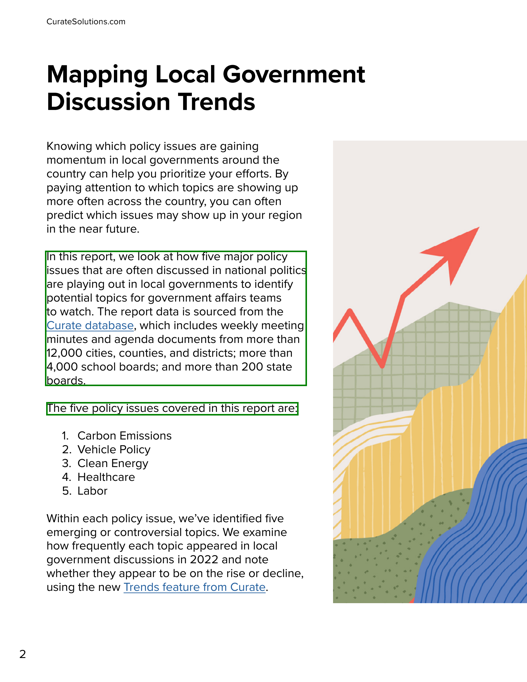

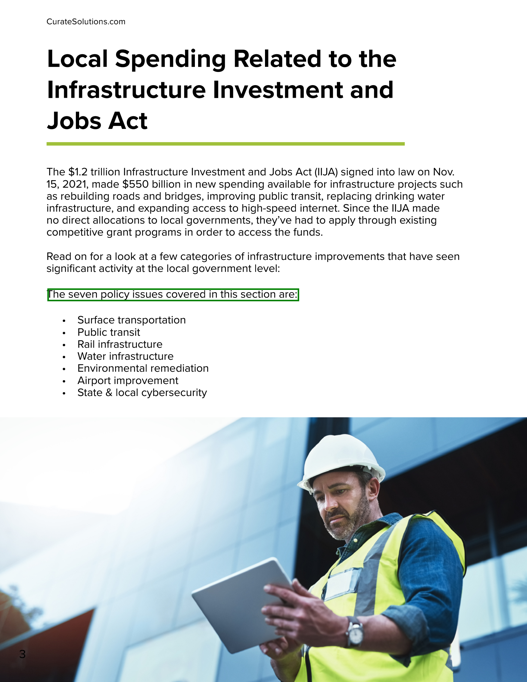

In [53]:
document_bot(question)

## Response

### Question

What are the main enviornmental topics this year?

### Answer

The main environmental topics this year are carbon emissions, vehicle policy, and clean energy.

### Sources
**Note:** The context used text from full pages. 
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* document: 1, relevance to question: 0.72
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* document: 1, relevance to question: 0.72
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* document: 1, relevance to question: 0.71
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* document: 1, relevance to question: 0.71
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.70        
    

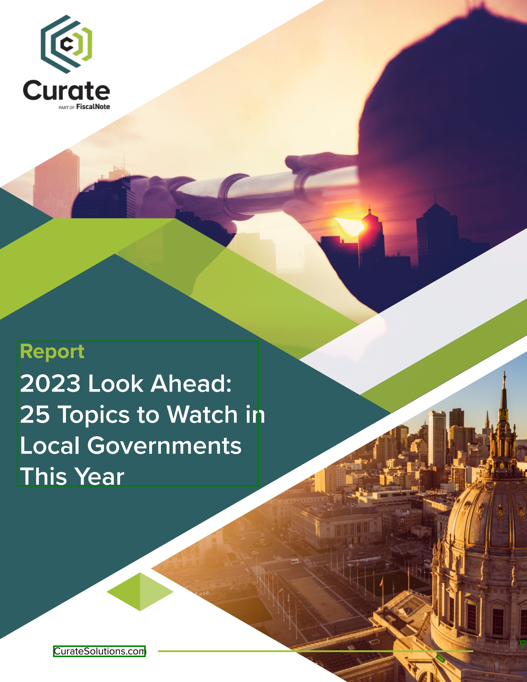

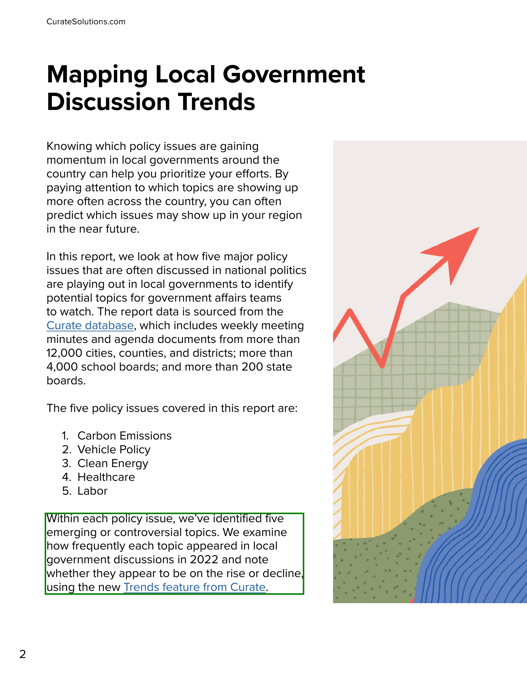

In [54]:
document_bot("What are the main enviornmental topics this year?")

## Response

### Question

How many discussion were used across all topics for Carbon Emissions?

### Answer

The answer is 6,263.

The question is "How many discussion were used across all topics for Carbon Emissions?".

The first context is about Carbon Emissions. It has 5 topics. The second context is about Vehicle Policy. The third context is about Clean Energy. The fourth context is about Mapping Local Government.

The question is about Carbon Emissions. So we need to look at the first context. The first context has 5 topics. The total number of discussions for all topics is 6,263.

### Sources
**Note:** The context used text from full pages. 
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=3
	* document: 3, relevance to question: 0.73
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=5
	* document: 5, relevance to question: 0.71
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=8
	* document: 8, relevance to question: 0.70
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=3
	* document: 3, relevance to question: 0.70
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.70        
    

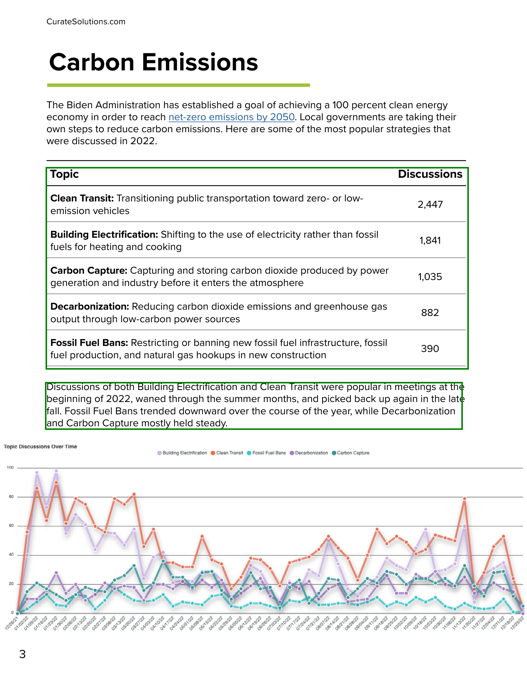

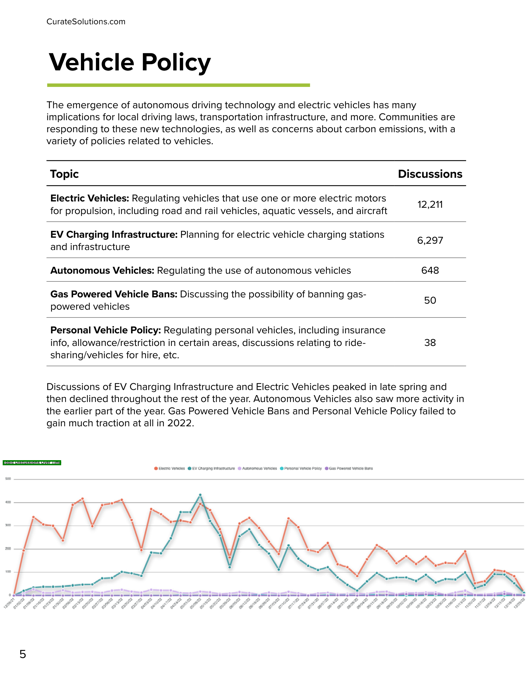

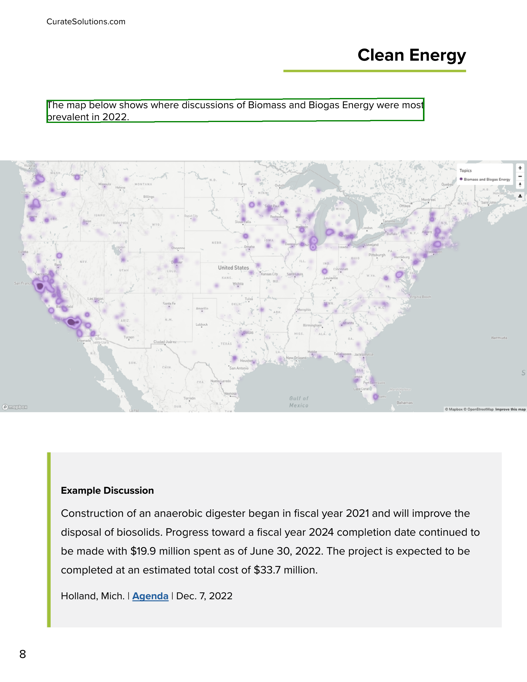

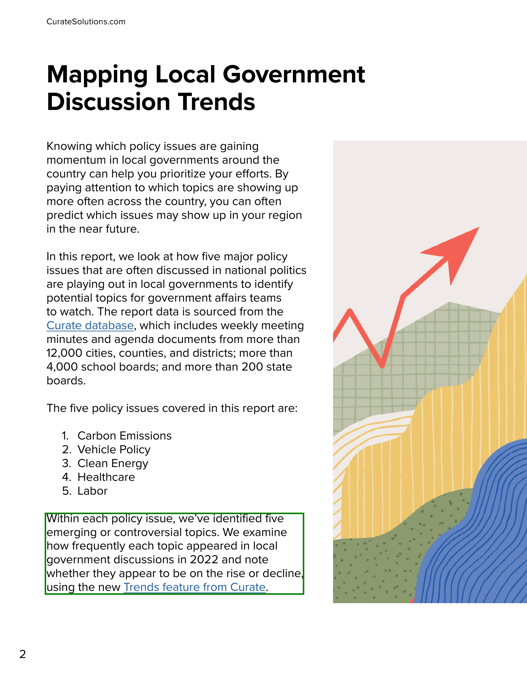

In [55]:
document_bot("How many discussion were used across all topics for Carbon Emissions?")

## Response

### Question

Which vehicle policy topic had the most discussions?

### Answer

The topic of Electric Vehicles had the most discussions in 2022. This is evident from the data in Context 1, which shows that there were 12,211 discussions of Electric Vehicles, compared to 6,297 discussions of EV Charging Infrastructure, 648 discussions of Autonomous Vehicles, 50 discussions of Gas Powered Vehicle Bans, and 38 discussions of Personal Vehicle Policy.

### Sources
**Note:** The context used text from full pages. 
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=5
	* document: 5, relevance to question: 0.73
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.73
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=5
	* document: 5, relevance to question: 0.73
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=5
	* document: 5, relevance to question: 0.73
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=6
	* document: 6, relevance to question: 0.73        
    

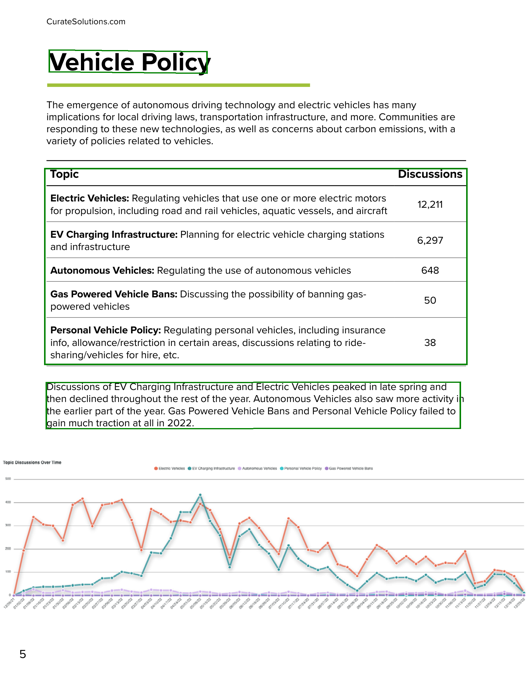

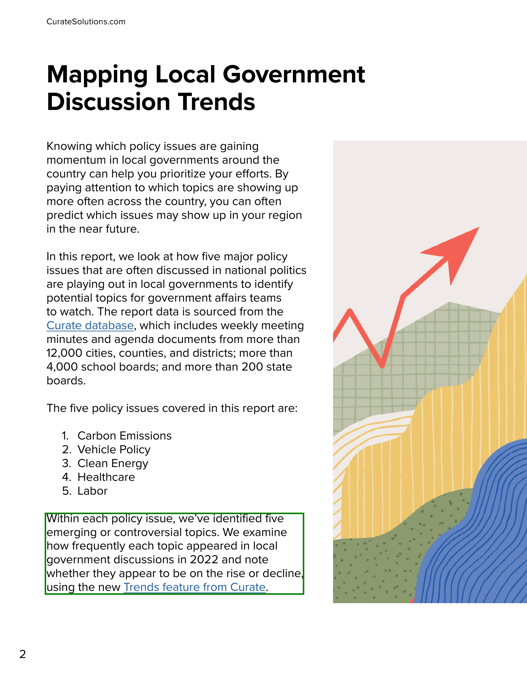

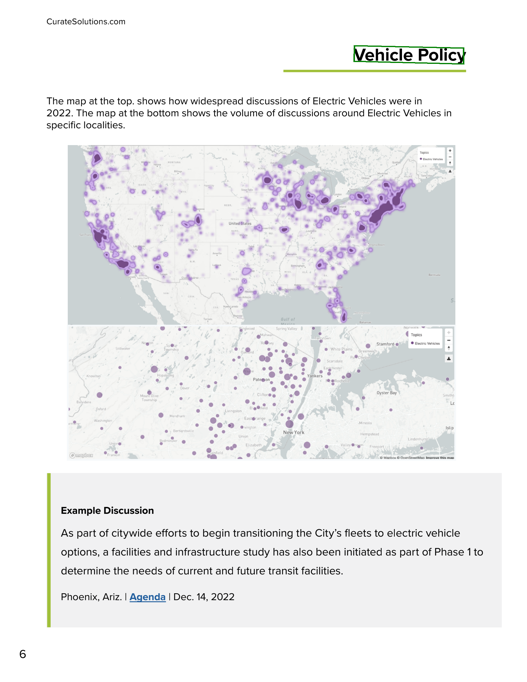

In [56]:
document_bot("Which vehicle policy topic had the most discussions?")